In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import argparse

import numpy as np
import torch.optim as optim
from torch.autograd import Variable

In [2]:
class MaskedLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """
    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

class MADE(nn.Module):
    def __init__(self, nin, hidden_sizes, nout, num_masks=1, natural_ordering=False):
        """
        nin: integer; number of inputs
        hidden sizes: a list of integers; number of units in hidden layers
        nout: integer; number of outputs, which usually collectively parameterize some kind of 1D distribution
              note: if nout is e.g. 2x larger than nin (perhaps the mean and std), then the first nin
              will be all the means and the second nin will be stds. i.e. output dimensions depend on the
              same input dimensions in "chunks" and should be carefully decoded downstream appropriately.
              the output of running the tests for this file makes this a bit more clear with examples.
        num_masks: can be used to train ensemble over orderings/connections
        natural_ordering: force natural ordering of dimensions, don't use random permutations
        """
        
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.hidden_sizes = hidden_sizes
        assert self.nout % self.nin == 0, "nout must be integer multiple of nin"
        
        # define a simple MLP neural net
        self.net = []
        hs = [nin] + hidden_sizes + [nout]
        for h0,h1 in zip(hs, hs[1:]):
            self.net.extend([
                    MaskedLinear(h0, h1),
                    nn.ReLU(),
                ])
        self.net.pop() # pop the last ReLU for the output layer
        self.net = nn.Sequential(*self.net)
        
        # seeds for orders/connectivities of the model ensemble
        self.natural_ordering = natural_ordering
        self.num_masks = num_masks
        self.seed = 0 # for cycling through num_masks orderings
        
        self.m = {}
        self.update_masks() # builds the initial self.m connectivity
        # note, we could also precompute the masks and cache them, but this
        # could get memory expensive for large number of masks.
        
    def update_masks(self):
        if self.m and self.num_masks == 1: return # only a single seed, skip for efficiency
        L = len(self.hidden_sizes)
        
        # fetch the next seed and construct a random stream
        rng = np.random.RandomState(self.seed)
        self.seed = (self.seed + 1) % self.num_masks
        
        # sample the order of the inputs and the connectivity of all neurons
        self.m[-1] = np.arange(self.nin) if self.natural_ordering else rng.permutation(self.nin)
        for l in range(L):
            self.m[l] = rng.randint(self.m[l-1].min(), self.nin-1, size=self.hidden_sizes[l])
        
        # construct the mask matrices
        masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
        masks.append(self.m[L-1][:,None] < self.m[-1][None,:])
        
        # handle the case where nout = nin * k, for integer k > 1
        if self.nout > self.nin:
            k = int(self.nout / self.nin)
            # replicate the mask across the other outputs
            masks[-1] = np.concatenate([masks[-1]]*k, axis=1)
        
        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l,m in zip(layers, masks):
            l.set_mask(m)
    
    def forward(self, x):
        return self.net(x)

# ------------------------------------------------------------------------------

if __name__ == '__main__':
    from torch.autograd import Variable
    
    # run a quick and dirty test for the autoregressive property
    D = 10
    rng = np.random.RandomState(14)
    x = (rng.rand(1, D) > 0.5).astype(np.float32)
    
    configs = [
        (D, [], D, False),                 # test various hidden sizes
        (D, [200], D, False),
        (D, [200, 220], D, False),
        (D, [200, 220, 230], D, False),
        (D, [200, 220], D, True),          # natural ordering test
        (D, [200, 220], 2*D, True),       # test nout > nin
        (D, [200, 220], 3*D, False),       # test nout > nin
    ]
    
    for nin, hiddens, nout, natural_ordering in configs:
        
        print("checking nin %d, hiddens %s, nout %d, natural %s" % 
             (nin, hiddens, nout, natural_ordering))
        model = MADE(nin, hiddens, nout, natural_ordering=natural_ordering)
        
        # run backpropagation for each dimension to compute what other
        # dimensions it depends on.
        res = []
        for k in range(nout):
            xtr = Variable(torch.from_numpy(x), requires_grad=True)
            xtrhat = model(xtr)
            loss = xtrhat[0,k]
            loss.backward()
            
            depends = (xtr.grad[0].numpy() != 0).astype(np.uint8)
            depends_ix = list(np.where(depends)[0])
            isok = k % nin not in depends_ix
            
            res.append((len(depends_ix), k, depends_ix, isok))
        
        # pretty print the dependencies
        res.sort()
        for nl, k, ix, isok in res:
            print("output %2d depends on inputs: %30s : %s" % (k, ix, "OK" if isok else "NOTOK"))
    

checking nin 10, hiddens [], nout 10, natural False
output  8 depends on inputs:                             [] : OK
output  4 depends on inputs:                            [8] : OK
output  0 depends on inputs:                         [4, 8] : OK
output  7 depends on inputs:                      [0, 4, 8] : OK
output  2 depends on inputs:                   [0, 4, 7, 8] : OK
output  9 depends on inputs:                [0, 2, 4, 7, 8] : OK
output  5 depends on inputs:             [0, 2, 4, 7, 8, 9] : OK
output  6 depends on inputs:          [0, 2, 4, 5, 7, 8, 9] : OK
output  1 depends on inputs:       [0, 2, 4, 5, 6, 7, 8, 9] : OK
output  3 depends on inputs:    [0, 1, 2, 4, 5, 6, 7, 8, 9] : OK
checking nin 10, hiddens [200], nout 10, natural False
output  8 depends on inputs:                             [] : OK
output  4 depends on inputs:                            [8] : OK
output  0 depends on inputs:                         [4, 8] : OK
output  7 depends on inputs:                    

In [8]:
from pyPDMP.utils import HDSint

In [9]:
k = 2                            # Spring Stiffness
b = 2                            # Damping coeff.
x0 = [5,0]                       # Initial Condition
t = np.linspace(0,10,1000)       # flow time span
Sigma = np.array([[5,0],[0,5]])  # Cov. of jump space dist. (Normal)
mu = np.array([0,0])             # Mean of jump space dist. (Normal)
tau = 0.4                        # Time constant of time jump space dist. (Cumulative Exp.)

# ODE of the flows
def fun(xi,t):
    x = xi[0]
    v = xi[1]
    return [xi[1],-k*xi[0]-b*xi[1]]

In [10]:
# Integrate Hybrid System
Ttot, Xtot, Xevent, Xreset, C = HDSint(5000,t,fun,x0,mu,Sigma,tau)

Progress:
25.0
50.0
75.0
100.0


Text(0.5, 0, 't')

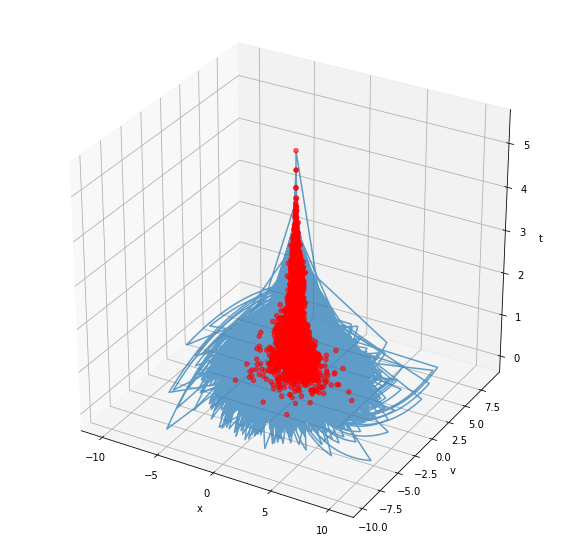

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot(xs = Xtot[:,0], ys = Xtot[:,1],zs = Xtot[:,2],alpha = 0.7)
ax.scatter(xs = Xevent[:,0], ys = Xevent[:,1],zs = Xevent[:,2],alpha = .6,color = 'red')
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.set_zlabel('t')

In [41]:
# Create Labels - NOT NEEDED FOR VAE
y = torch.tensor([1 for i in range(Xevent.shape[0])]).numpy()

X = torch.tensor(Xevent).float().numpy()
X = 2*(X - X.min(0)[0])/(X.max(0)[0] - X.min(0)[0]) - 1

print(X.shape,y.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

(5000, 3) (5000,)


In [66]:
m = MADE(3, [200], 6, natural_ordering=natural_ordering)
print("number of model parameters:",sum([np.prod(p.size()) for p in m.parameters()]))
m

number of model parameters: 2006


MADE(
  (net): Sequential(
    (0): MaskedLinear(in_features=3, out_features=200, bias=True)
    (1): ReLU()
    (2): MaskedLinear(in_features=200, out_features=6, bias=True)
  )
)

In [67]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
    
# load the dataset
xtr, xte = X_train, X_test
xtr = torch.from_numpy(xtr)#.cuda()
xte = torch.from_numpy(xte)#.cuda()

In [68]:
def run_epoch(split, samples, resample_every = 20, upto=None):
    torch.set_grad_enabled(split=='train') # enable/disable grad for efficiency of forwarding test batches
    model.train() if split == 'train' else m.eval()
    nsamples = 1 if split == 'train' else samples
    x = xtr if split == 'train' else xte
    N,D = x.size()
    B = 1 # batch size
    nsteps = N//B if upto is None else min(N//B, upto)
    lossfs = []
    for step in range(nsteps):
        # fetch the next batch of data
        xb = Variable(x[step*B:step*B+B])
        # get the logits, potentially run the same batch a number of times, resampling each time
        xbhat = torch.zeros_like(xb)
        for s in range(nsamples):
            # perform order/connectivity-agnostic training by resampling the masks
            if step % resample_every == 0 or split == 'test': # if in test, cycle masks every time
                m.update_masks()
            # forward the model
            xbhat += m(xb)
        xbhat /= nsamples
        
        # evaluate the binary cross entropy loss
        loss = F.binary_cross_entropy_with_logits(xbhat, xb, reduction='sum') / B
        lossf = loss.data.item()
        lossfs.append(lossf)
        
        # backward/update
        if split == 'train':
            opt.zero_grad()
            loss.backward()
            opt.step()
        
    print("%s epoch average loss: %f" % (split, np.mean(lossfs)))

In [69]:
# set up the optimizer
opt = torch.optim.Adam(m.parameters(), 1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=45, gamma=0.1)
    
# start the training
for epoch in range(10):
    print("epoch %d" % (epoch, ))
    scheduler.step(epoch)
    run_epoch('test', 500, upto=5) # run only a few batches for approximate test accuracy
    run_epoch('train',500)
    
print("optimization done. full test set eval:")
run_epoch('test',500)

epoch 0


RuntimeError: The size of tensor a (3) must match the size of tensor b (6) at non-singleton dimension 1

In [65]:
m(xtr[4])

tensor([-9.2195e+06, -3.3367e+06, -1.6935e+00], grad_fn=<AddBackward0>)